# Ephys Code #

In [1]:
import pyabf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as sp
from scipy.interpolate import CubicSpline, interp1d
from scipy.signal import savgol_filter, find_peaks
from scipy.ndimage import gaussian_filter1d

In [2]:
# load abf
abf = pyabf.ABF("C:/Users/bbyer/OneDrive/Documents/UniversityofKentucky/BachstetterLab/ephys_toolbox/ephys_toolbox/data/2025_03_06_0000.abf")

In [3]:
sweep_list = abf.sweepList
num_traces = int(input("Enter number of stim sweeps: "))

In [4]:
sweep_indices = [sweep_list[i:i + num_traces] for i in range(0, len(sweep_list), num_traces)]

sweep_stims = ["amp25","amp50","amp75","amp100","amp150","amp200","amp250","amp300","amp400","amp500","amp600"]

def build_sweeps(abf, sweep_stims, sweep_indices, conversion_fct=1000):
    records = []
    for stim, idxs in zip(sweep_stims, sweep_indices):
        for sweep_id, i in enumerate(idxs, start=1):
            abf.setSweep(i)
            x = abf.sweepX.copy()
            y = abf.sweepY.copy()
            # Flatten into records
            for t, val in zip(x, y):
                records.append((stim, sweep_id, t, val))
    df = pd.DataFrame(records, columns=["stimulus", "sweep", "time", "value"])
    return df

df = build_sweeps(abf, sweep_stims=sweep_stims, sweep_indices=sweep_indices)
display(df)

,stimulus,sweep,time,value
0,amp25,1,0.00000,1.162720
1,amp25,1,0.00005,1.239014
2,amp25,1,0.00010,1.223755
3,amp25,1,0.00015,1.193237
4,amp25,1,0.00020,1.156616
...,...,...,...,...
16495,amp600,3,0.02475,0.762939
16496,amp600,3,0.02480,0.750732
16497,amp600,3,0.02485,0.762939
16498,amp600,3,0.02490,0.765991


In [5]:
def normalize_abf(abf_df):
    df = abf_df.copy()

    # subtract first point of each sweep
    df["t0"] = df.groupby(["stimulus", "sweep"])["value"].transform(lambda x: x.iloc[0])
    df["value"] = df["value"] - df["t0"]

    # reset time per sweep so each starts at 0
    df["time0"] = df.groupby(["stimulus", "sweep"])["time"].transform(lambda x: x.iloc[0])
    df["time"] = df["time"] - df["time0"]

    df.drop(columns=["t0", "time0"], inplace=True)
    return df

normalized = normalize_abf(df)

In [6]:
def remove_stim_artifact(abf_df, pulse_width=0.5e-3, fs=20e3, multiplier=3, std=2.0, K=60):
    """
    Remove stimulation artifact in sweeps using robust MAD detection + local interpolation.

    Parameters
    ----------
    abf_df : DataFrame with columns ["time", "value", "stimulus"]
        LFP sweeps grouped by 'stimulus'.
    pulse_width : float
        Stimulus pulse width (seconds per phase).
    fs : int
        Sampling frequency in Hz.
    multiplier : int
        How many pulse widths forward to mask after onset.
    std : float
        Threshold multiplier for robust MAD (default = 2).
    C: int
        Constant for amp stim removal padding
    """

    def process_group(group):
        g = group.copy()
        x = g["time"].to_numpy()
        y = g["value"].to_numpy()

        # calculate derivative + MAD threshold
        dy = np.gradient(y, x)

        search_window_sec = multiplier * pulse_width
        search_window_samples = int(search_window_sec * fs)

        slope_window = dy[:search_window_samples]
        med_dy = np.median(slope_window)
        mad_dy = np.median(np.abs(slope_window - med_dy))
        T = 1.4826
        thr_dy = std * T * mad_dy

        # detect slope outliers in axis = 0
        outliers = np.where(np.abs(slope_window) > thr_dy)[0]

        if len(outliers) == 0:
            g["clean"] = y
            return g
        
        # artifact bounds
        start_idx = max(1, outliers[0] - 1)
        end_idx   = min(len(x) - 2, outliers[-1] + 1)
       
        stim = g["stimulus"].iloc[0]   # e.g. "amp25"
        amp  = int(stim.replace("amp", ""))
        pad  = int(round(K / np.sqrt(amp)))

        # anchors with ±pad
        lo = max(0, start_idx - pad)
        hi = min(len(x) - 1, end_idx + pad)

        y_fixed = y.copy()
        mask_bad = (x >= x[lo]) & (x <= x[hi])
        
        # linear interpolation
        y_fixed[mask_bad] = np.interp(
            x[mask_bad],
            [x[lo], x[hi]],
            [y[lo], y[hi]]
        )

        g["clean"] = y_fixed
        return g

    return abf_df.groupby("stimulus", group_keys=False)[['stimulus', 'sweep', 'time', 'value']].apply(process_group)

removed = remove_stim_artifact(abf_df=normalized)
display(removed)

,stimulus,sweep,time,value,clean
0,amp25,1,0.00000,0.000000,0.000000
1,amp25,1,0.00005,0.076294,0.000000
2,amp25,1,0.00010,0.061035,0.000000
3,amp25,1,0.00015,0.030518,0.000000
4,amp25,1,0.00020,-0.006104,0.000000
...,...,...,...,...,...
16495,amp600,3,0.02475,-0.167847,-0.167847
16496,amp600,3,0.02480,-0.180054,-0.180054
16497,amp600,3,0.02485,-0.167847,-0.167847
16498,amp600,3,0.02490,-0.164795,-0.164795


In [7]:
def average_traces(abf_df):
    df_summary = (
        abf_df
        .groupby(["stimulus", "time"])
        .agg(
            mean_value=("clean", "mean"),
            sem_value=("clean", lambda x: x.std(ddof=1)/np.sqrt(len(x))) # standard error of the mean, std/sqrt(n)
        )
        .reset_index()
    )
    return df_summary

averaged = average_traces(removed)
display(averaged)

,stimulus,time,mean_value,sem_value
0,amp100,0.00000,0.000000,0.000000
1,amp100,0.00005,-0.045776,0.000000
2,amp100,0.00010,-0.042089,0.000000
3,amp100,0.00015,-0.038401,0.000000
4,amp100,0.00020,-0.034714,0.000000
...,...,...,...,...
5495,amp75,0.02475,0.022380,0.010620
5496,amp75,0.02480,0.014242,0.007121
5497,amp75,0.02485,0.026449,0.007945
5498,amp75,0.02490,0.025431,0.017383


In [8]:
def smooth_curves(abf_df, method="gaussian", win_len=40, poly=2, K=60):
    def process_group(group):
        g = group.copy()
        mean = g["mean_value"].to_numpy()

        if method == "gaussian":
            stim = g["stimulus"].iloc[0]   # e.g. "amp25"
            amp  = int(stim.replace("amp", ""))
            sigma  = int(round(K / np.sqrt(amp)))
            mean_smooth = gaussian_filter1d(mean, sigma=sigma, mode="reflect")
        if method == "savgol":
            mean_smooth = savgol_filter(mean, window_length=win_len, polyorder=poly, mode="interp")
        
        g["mean_smooth"] = mean_smooth

        return g
    
    return abf_df.groupby("stimulus", group_keys=False)[['stimulus', 'time', 'mean_value', 'sem_value']].apply(process_group)
smoothed = smooth_curves(averaged, K=30)
display(smoothed)

,stimulus,time,mean_value,sem_value,mean_smooth
0,amp100,0.00000,0.000000,0.000000,-0.029519
1,amp100,0.00005,-0.045776,0.000000,-0.029875
2,amp100,0.00010,-0.042089,0.000000,-0.030297
3,amp100,0.00015,-0.038401,0.000000,-0.030359
4,amp100,0.00020,-0.034714,0.000000,-0.029709
...,...,...,...,...,...
5495,amp75,0.02475,0.022380,0.010620,0.022981
5496,amp75,0.02480,0.014242,0.007121,0.023548
5497,amp75,0.02485,0.026449,0.007945,0.024079
5498,amp75,0.02490,0.025431,0.017383,0.024519


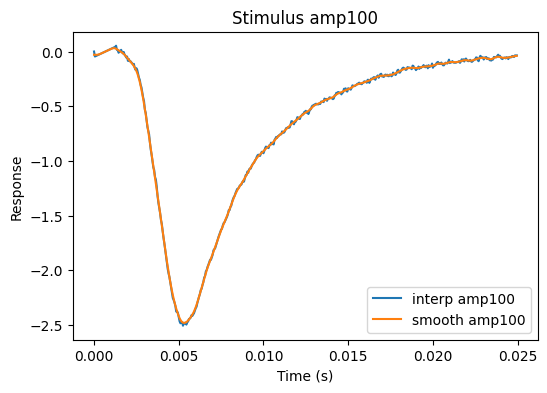

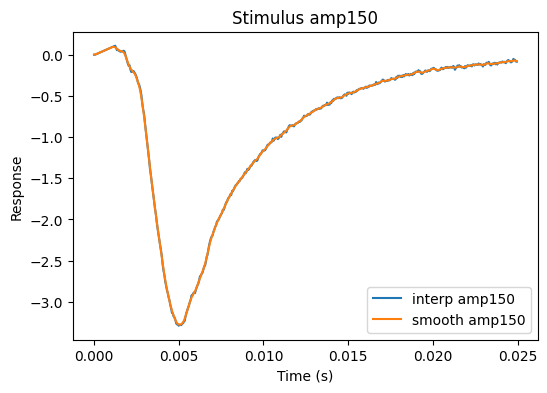

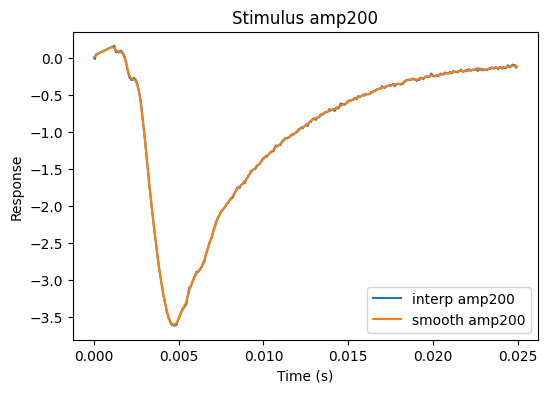

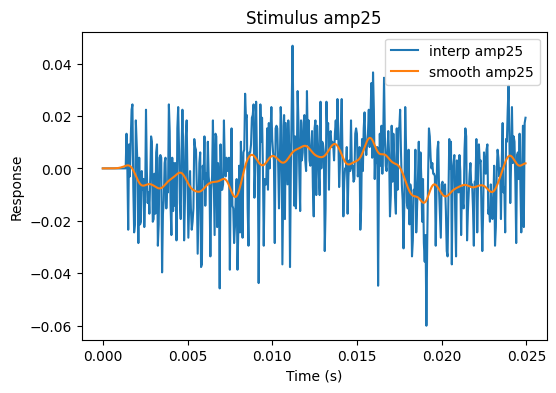

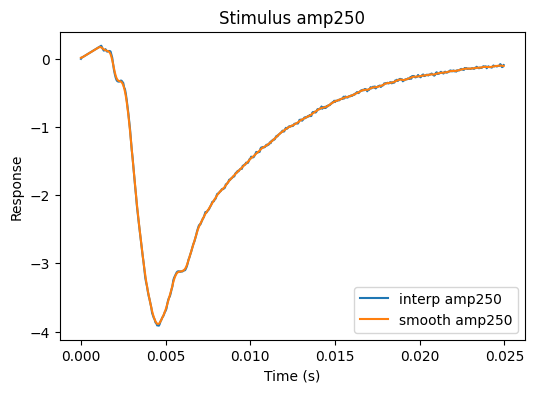

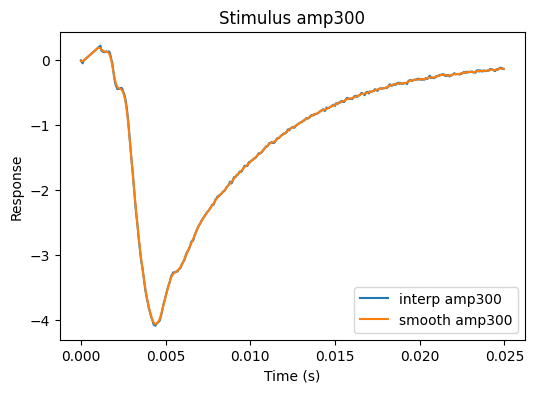

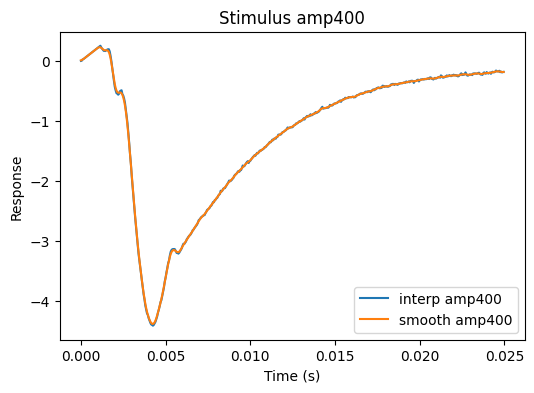

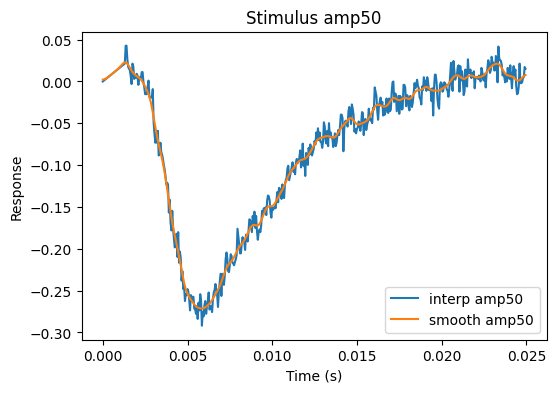

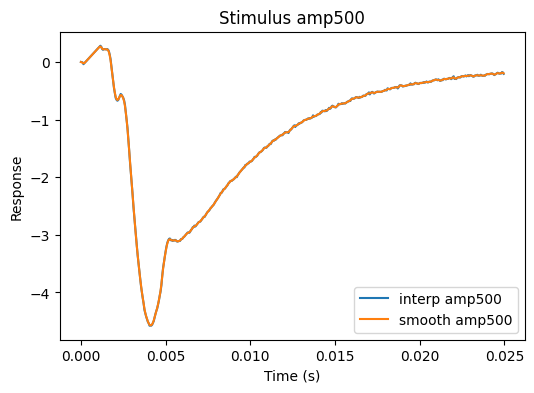

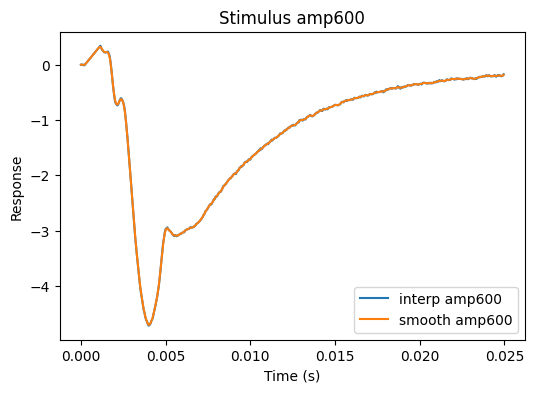

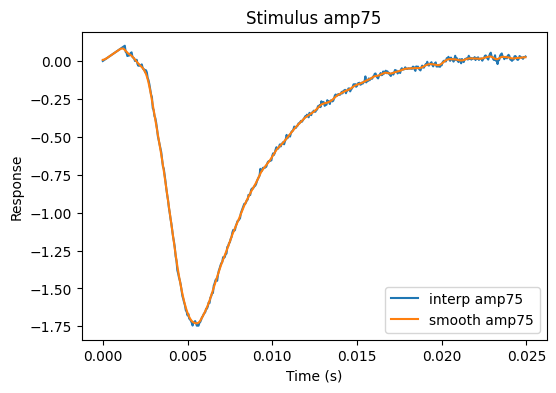

In [9]:
def plot_traces(df_summary):
    for stim, sub in df_summary.groupby("stimulus"):
        plt.figure(figsize=(6,4))
        plt.plot(sub["time"] , sub["mean_value"], label=f"interp {stim}")
        plt.plot(sub["time"], sub["mean_smooth"], label=f"smooth {stim}")
        plt.title(f"Stimulus {stim}")
        plt.xlabel("Time (s)")
        plt.ylabel("Response")
        plt.legend()
        plt.show()

plot = plot_traces(smoothed)

Stimulus amp100: FV start=0.001550s, end=0.002100s, amplitude=0.086 mV


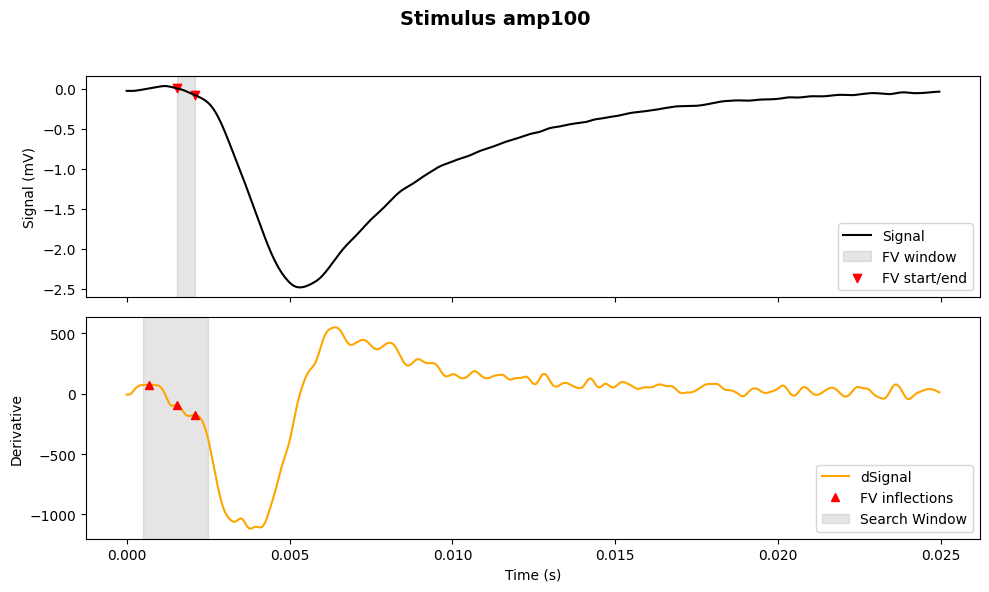

Stimulus amp150: FV start=0.001600s, end=0.002300s, amplitude=0.248 mV


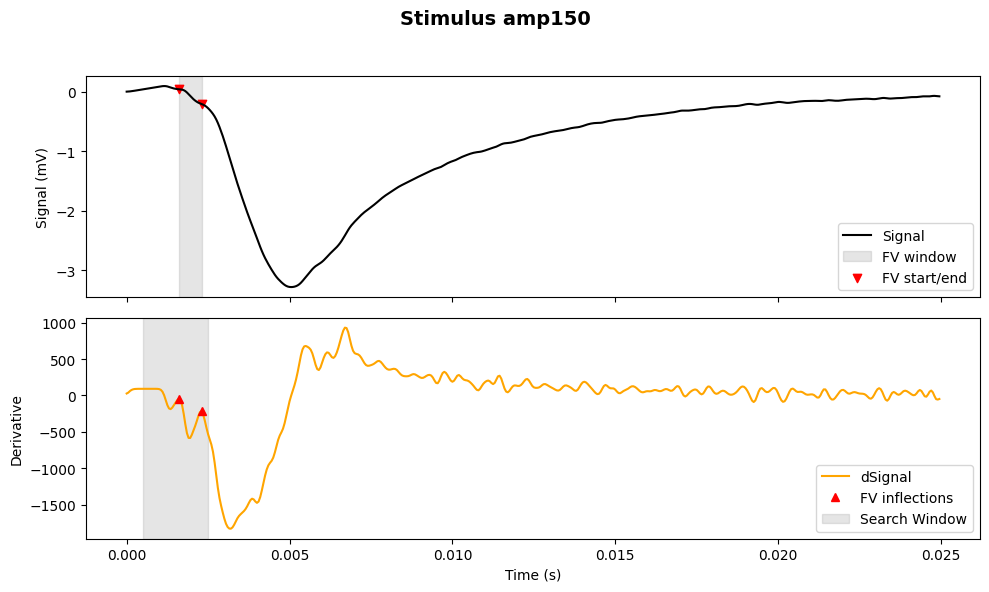

Stimulus amp200: FV start=0.001500s, end=0.002300s, amplitude=0.369 mV


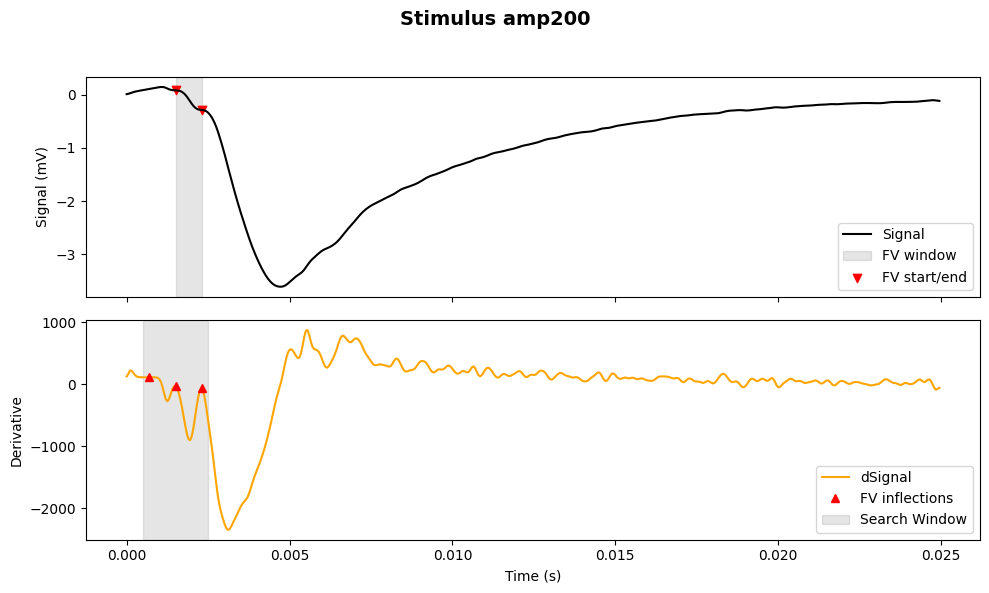

Stimulus amp25: insufficient peaks (1)


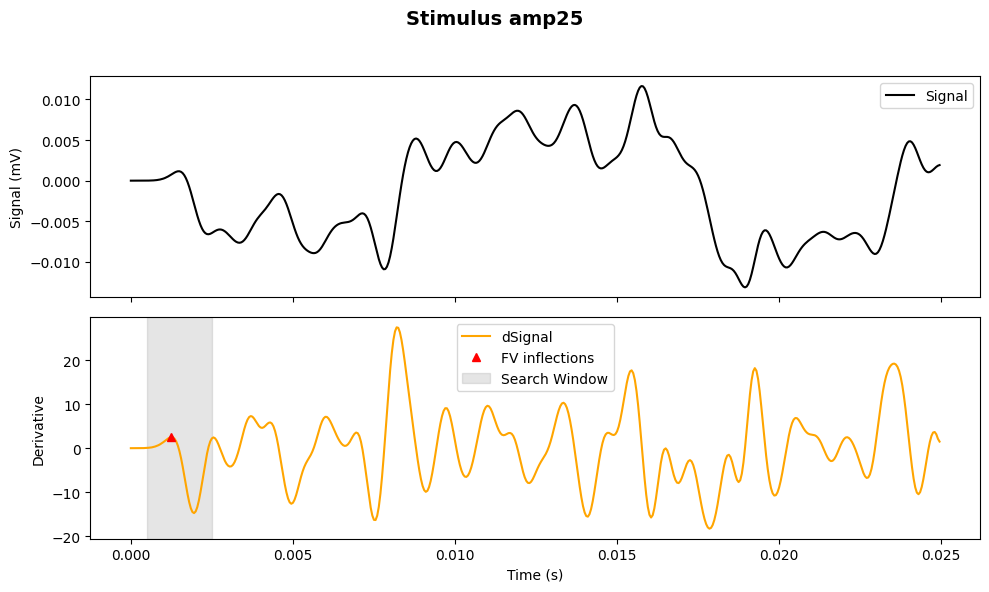

Stimulus amp250: FV start=0.001500s, end=0.002300s, amplitude=0.450 mV


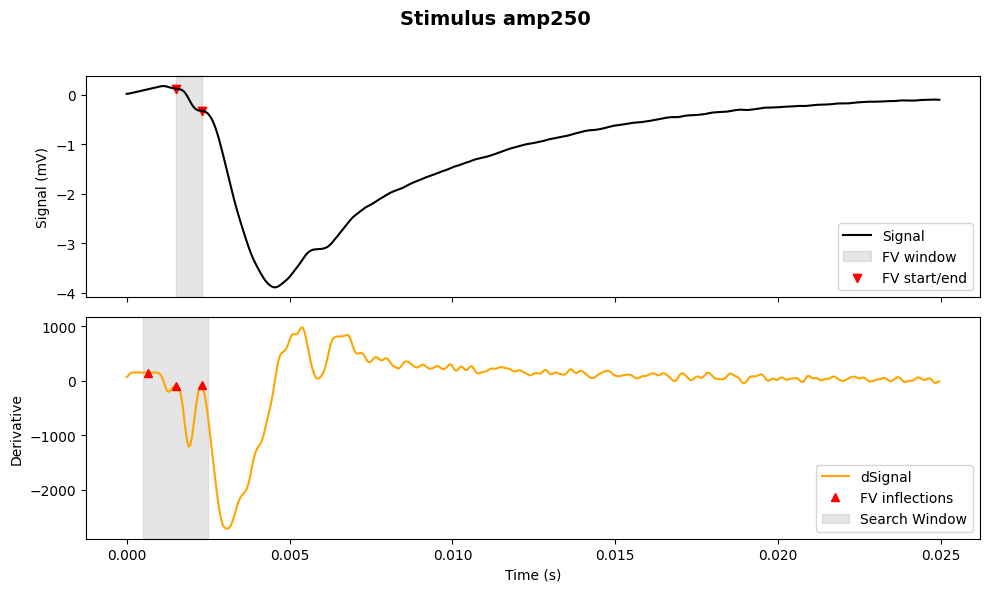

Stimulus amp300: FV start=0.001450s, end=0.002300s, amplitude=0.569 mV


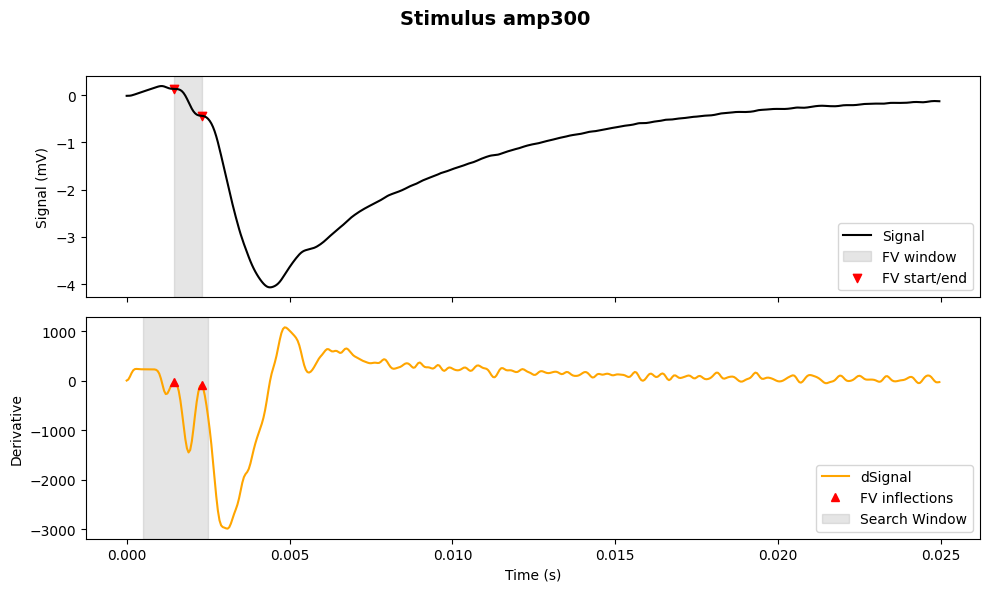

Stimulus amp400: FV start=0.001450s, end=0.002250s, amplitude=0.707 mV


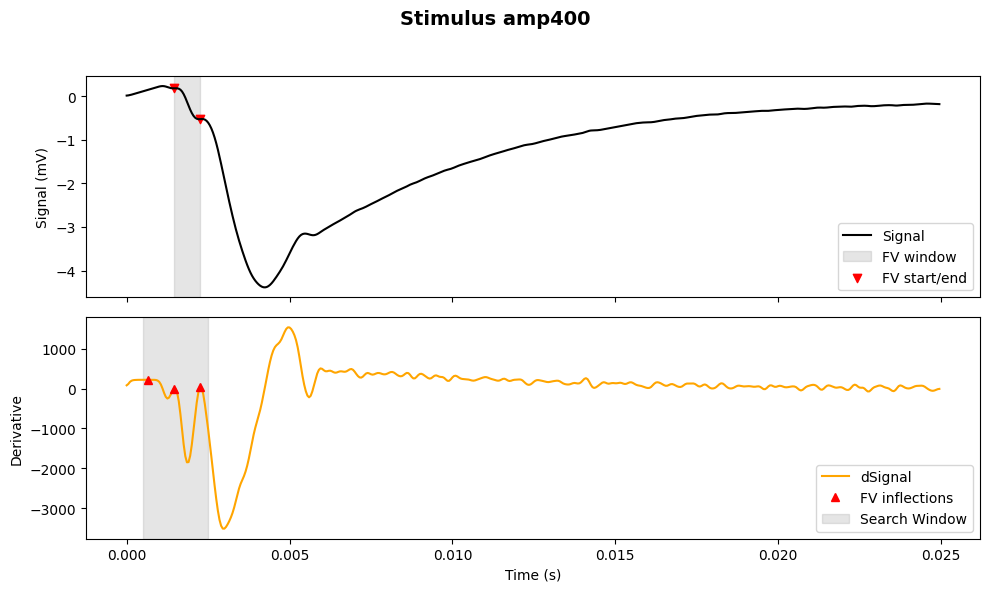

Stimulus amp50: FV start=0.001100s, end=0.002050s, amplitude=0.014 mV


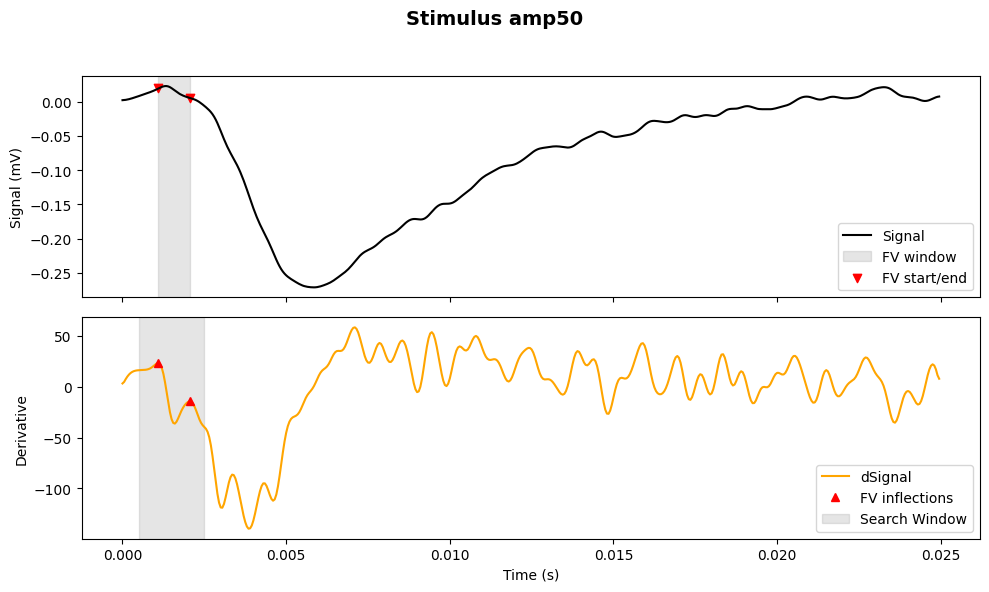

Stimulus amp500: FV start=0.001400s, end=0.002250s, amplitude=0.846 mV


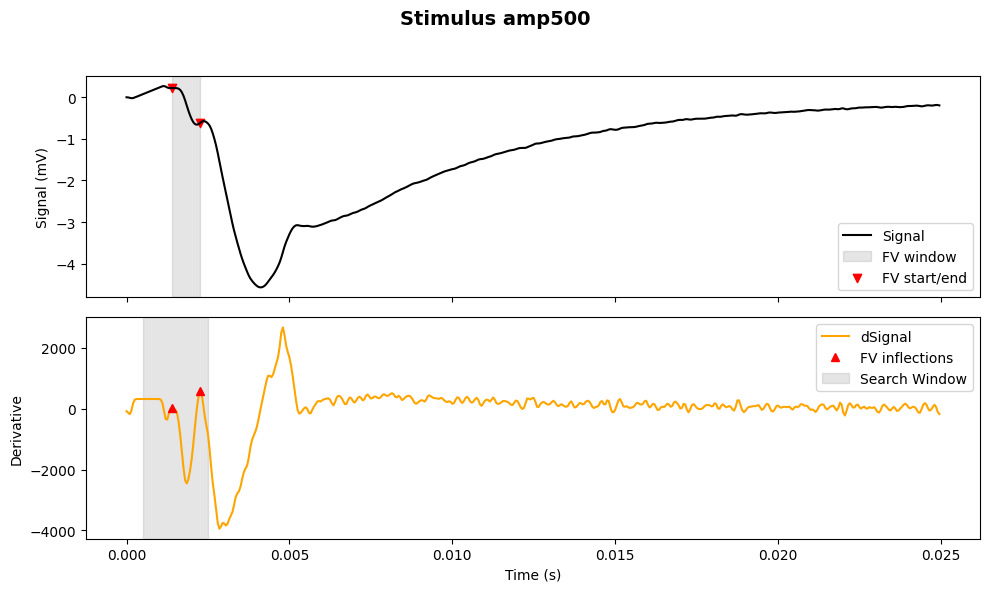

Stimulus amp600: FV start=0.001500s, end=0.002250s, amplitude=0.905 mV


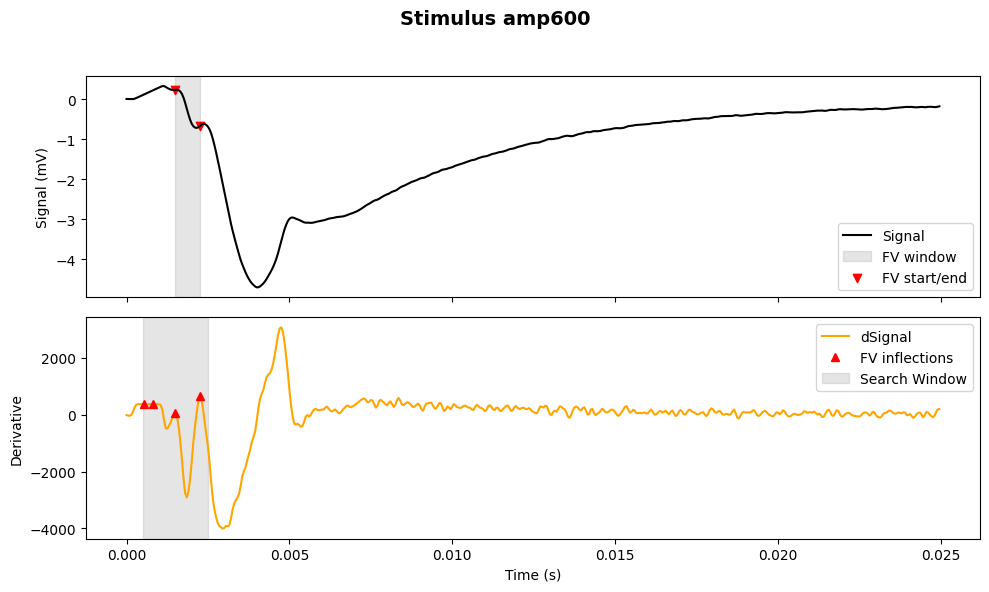

Stimulus amp75: FV start=0.001600s, end=0.002200s, amplitude=0.070 mV


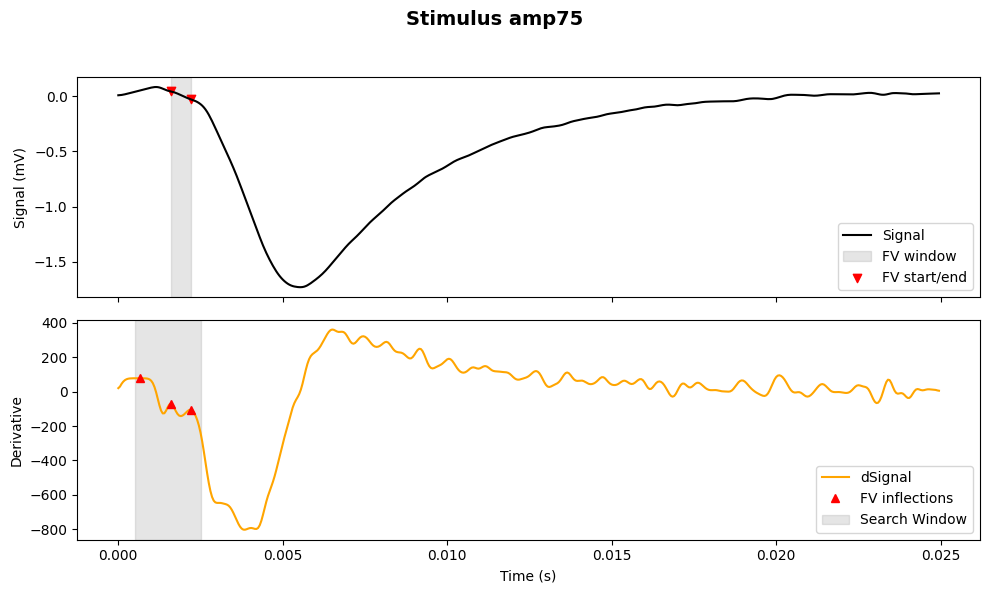

C:\Users\bbyer\AppData\Local\Temp\ipykernel_37124\3781867700.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return smoothed_df.groupby("stimulus", group_keys=False)[['stimulus', 'time', 'mean_value', 'sem_value', 'mean_smooth']].apply(process_group).dropna(how="all")


,stimulus,time,mean_value,sem_value,mean_smooth,fv_max,fv_min,fv_amplitude
1500,amp25,0.00000,0.000000,0.000000,0.000000e+00,NaN,NaN,NaN
1501,amp25,0.00005,0.000000,0.000000,0.000000e+00,NaN,NaN,NaN
1502,amp25,0.00010,0.000000,0.000000,0.000000e+00,NaN,NaN,NaN
1503,amp25,0.00015,0.000000,0.000000,0.000000e+00,NaN,NaN,NaN
1504,amp25,0.00020,0.000000,0.000000,2.949810e-07,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1995,amp25,0.02475,0.001017,0.008868,1.336814e-03,NaN,NaN,NaN
1996,amp25,0.02480,0.016276,0.028700,1.526086e-03,NaN,NaN,NaN
1997,amp25,0.02485,-0.022380,0.025492,1.704178e-03,NaN,NaN,NaN
1998,amp25,0.02490,0.017293,0.034180,1.841953e-03,NaN,NaN,NaN


In [ ]:
def calculate_fv_amplitude(smoothed_df, fs=20e3):
    def process_group(group):
        if group.empty or group["mean_smooth"].isna().all():
            return pd.DataFrame()  # return empty df safely
        g = group.copy()
        stim = group.name
        x = g["time"].to_numpy()
        y = g["mean_smooth"].to_numpy()

        # derivative
        dy = np.gradient(y, x)

        # --- dynamic threshold for peak detection
        fv_start_search = 0.5e-3 
        fv_end_search = 2.5e-3

        start_idx = int(fv_start_search * fs)
        end_idx = int(fv_end_search * fs)

        slope_window = dy[start_idx:end_idx]
        x_window = x[start_idx:end_idx]

        # find peaks in search window
        peak_indices, _ = find_peaks(slope_window)

        fv_amp = np.nan
        fv_start = fv_end = None

        if len(peak_indices) >= 2:
            # take the last two peaks (fiber volley start and end)
            last_two = peak_indices[-2:]
            fv_start_idx = start_idx + last_two[0]
            fv_end_idx = start_idx + last_two[1]
            fv_start = x[fv_start_idx]
            fv_end = x[fv_end_idx]
            fv_max = y[fv_start_idx]
            fv_min = y[fv_end_idx]
            fv_amp = fv_max - fv_min
            g["fv_max"] = fv_max
            g["fv_min"] = fv_min
            print(f"Stimulus {stim}: FV start={fv_start:.6f}s, end={fv_end:.6f}s, amplitude={fv_amp:.3f} mV")
        else:
            print(f"Stimulus {stim}: insufficient peaks ({len(peak_indices)})")

        # --- plotting
        fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        fig.suptitle(f"Stimulus {stim}", fontsize=14, fontweight='bold')

        # Plot y
        axs[0].plot(x, y, label='Signal', color='black')
        if fv_start and fv_end:
            axs[0].axvspan(fv_start, fv_end, color='gray', alpha=0.2, label='FV window')
            axs[0].scatter([fv_start, fv_end], [y[int(fv_start_idx)], y[int(fv_end_idx)]],
                           color='red', marker='v', label='FV start/end')
        axs[0].set_ylabel('Signal (mV)')
        axs[0].legend()

        # Plot dy
        axs[1].plot(x, dy, label='dSignal', color='orange')
        axs[1].plot(x_window[peak_indices], slope_window[peak_indices], '^',
                    color='red', label='FV inflections')
        axs[1].axvspan(x[start_idx], x[end_idx], color='gray', alpha=0.2, label='Search Window')
        axs[1].set_ylabel('Derivative')
        axs[1].set_xlabel('Time (s)')
        axs[1].legend()

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        # store FV amplitude in the group DataFrame
        g["fv_amplitude"] = fv_amp
        return g

    return smoothed_df.groupby("stimulus", group_keys=False)[['stimulus', 'time', 'mean_value', 'sem_value', 'mean_smooth']].apply(process_group).dropna(how="all")
    
fv_amp = calculate_fv_amplitude(smoothed)
fv_amp = fv_amp[fv_amp['stimulus'] == 'amp25']
display(fv_amp)
        

Stimulus amp100: FV start=0.001550s, end=0.002100s, amplitude=0.086 mV
Stimulus amp100: EPSP trough=-2.480 mV at 0.005300s
Stimulus amp100: EPSP amplitude=2.396356 mV


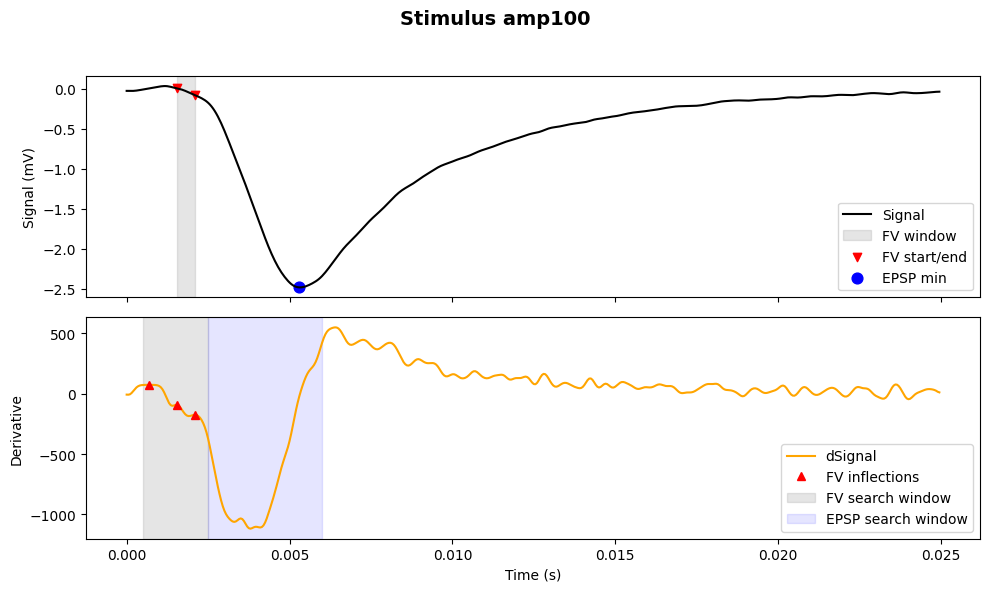

Stimulus amp150: FV start=0.001600s, end=0.002300s, amplitude=0.248 mV
Stimulus amp150: EPSP trough=-3.278 mV at 0.005050s
Stimulus amp150: EPSP amplitude=3.072928 mV


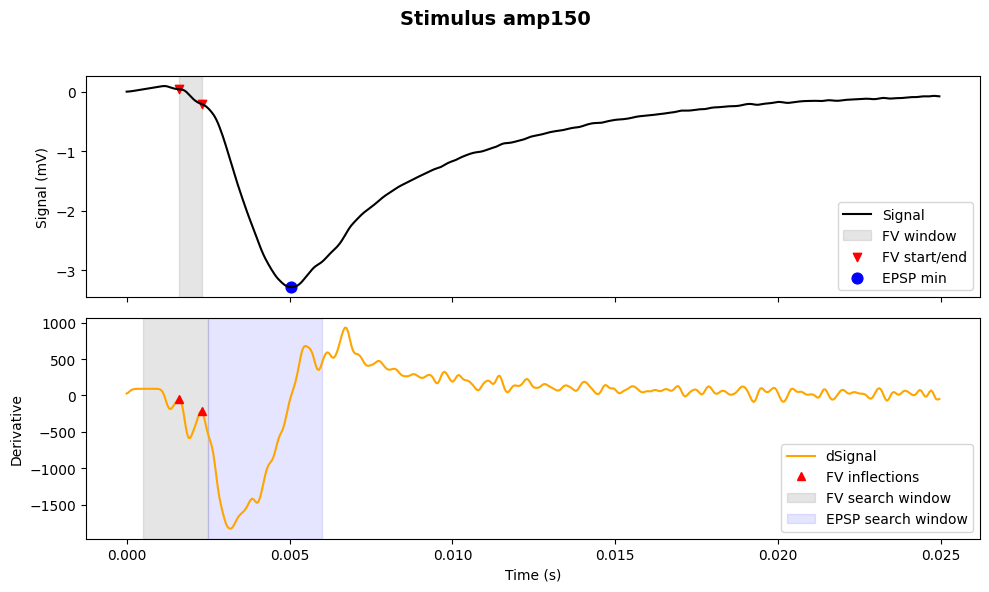

Stimulus amp200: FV start=0.001500s, end=0.002300s, amplitude=0.369 mV
Stimulus amp200: EPSP trough=-3.605 mV at 0.004700s
Stimulus amp200: EPSP amplitude=3.319312 mV


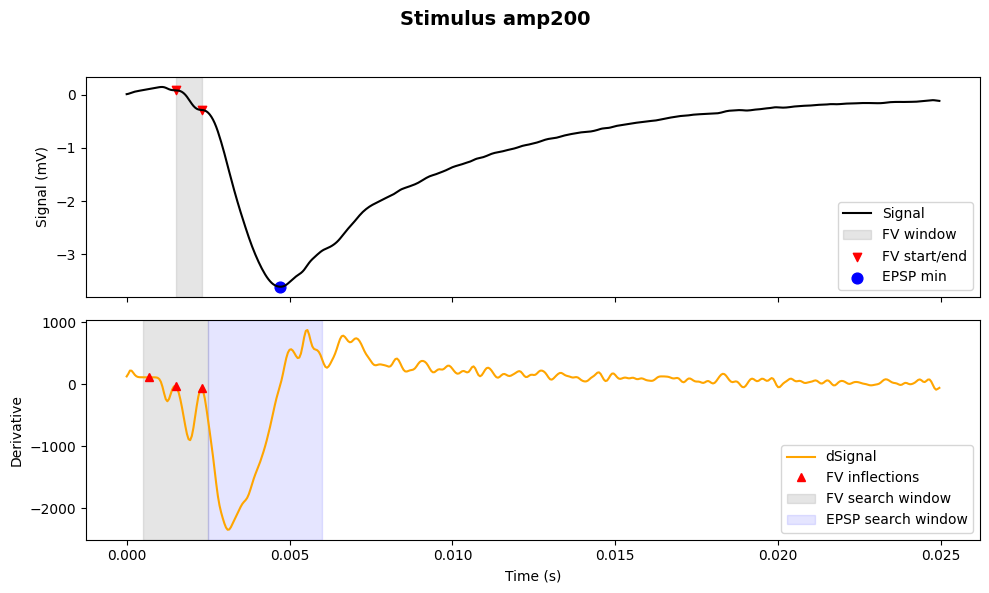

Stimulus amp25: insufficient FV peaks (1)
Stimulus amp25: EPSP trough=-0.009 mV at 0.005650s
Stimulus amp25: EPSP amplitude not found.


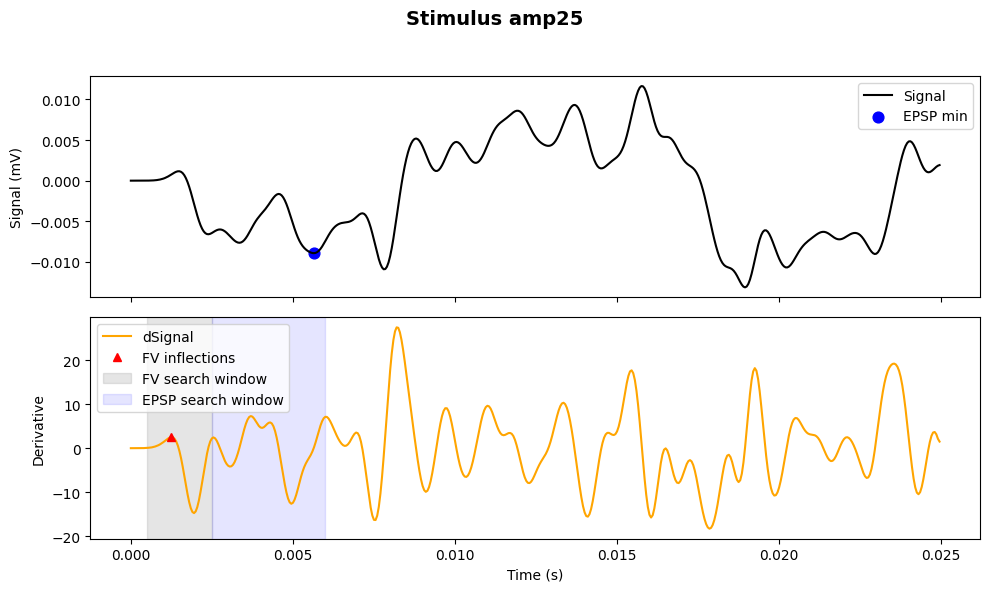

Stimulus amp250: FV start=0.001500s, end=0.002300s, amplitude=0.450 mV
Stimulus amp250: EPSP trough=-3.890 mV at 0.004550s
Stimulus amp250: EPSP amplitude=3.561582 mV


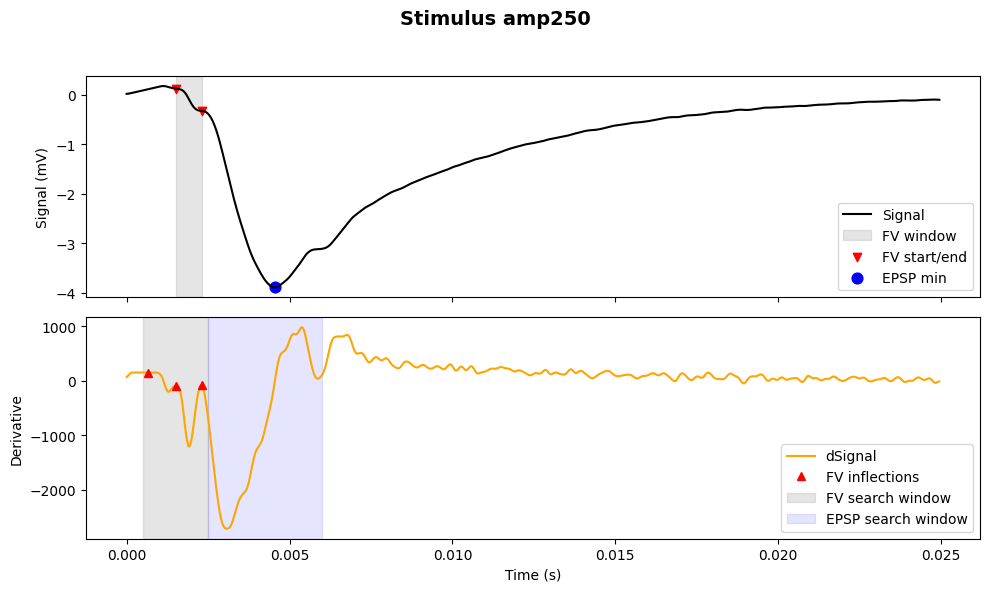

Stimulus amp300: FV start=0.001450s, end=0.002300s, amplitude=0.569 mV
Stimulus amp300: EPSP trough=-4.067 mV at 0.004400s
Stimulus amp300: EPSP amplitude=3.631126 mV


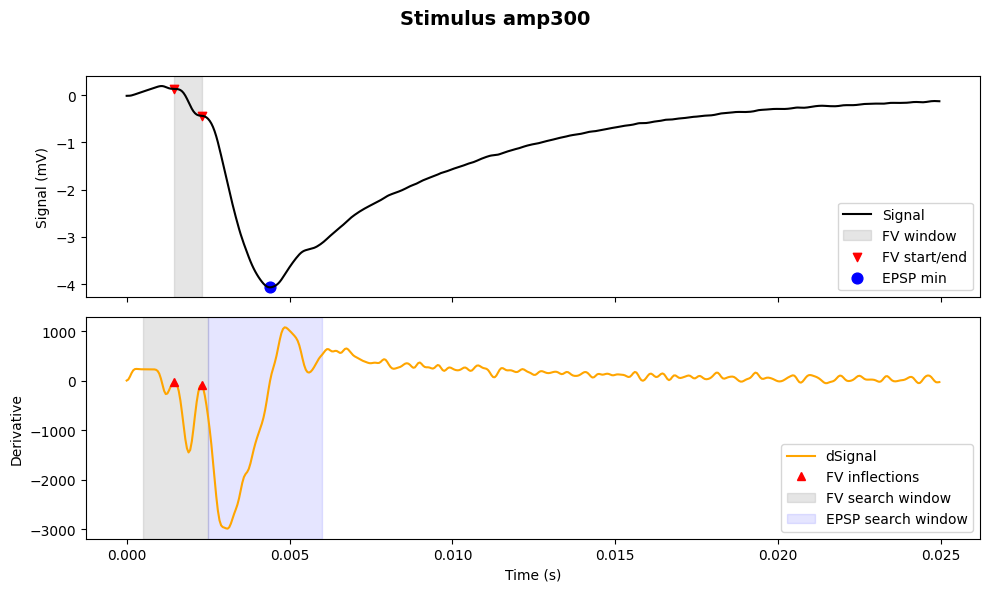

Stimulus amp400: FV start=0.001450s, end=0.002250s, amplitude=0.707 mV
Stimulus amp400: EPSP trough=-4.385 mV at 0.004250s
Stimulus amp400: EPSP amplitude=3.855006 mV


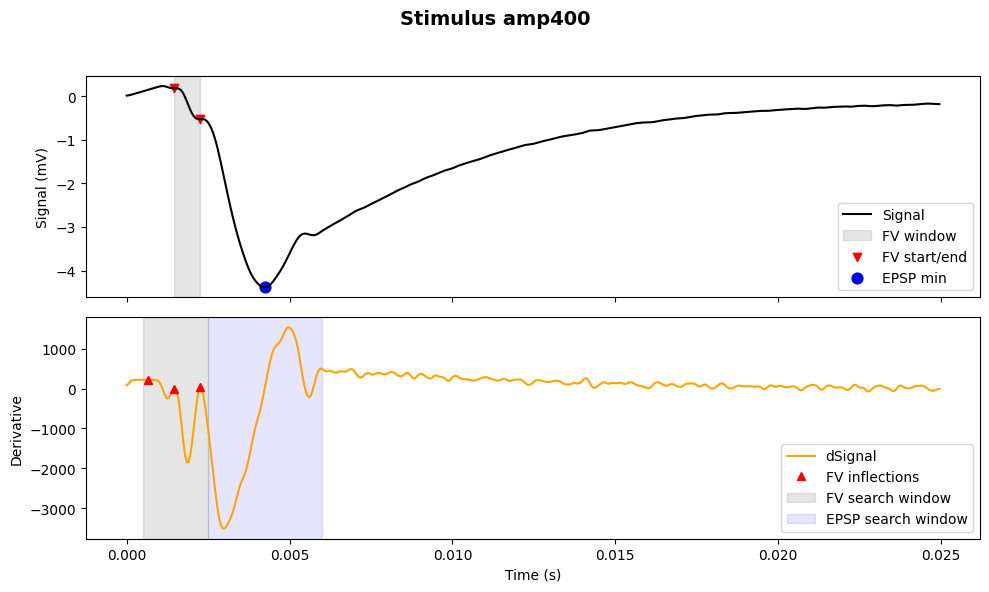

Stimulus amp50: FV start=0.001100s, end=0.002050s, amplitude=0.014 mV
Stimulus amp50: EPSP trough=-0.271 mV at 0.005850s
Stimulus amp50: EPSP amplitude=0.277019 mV


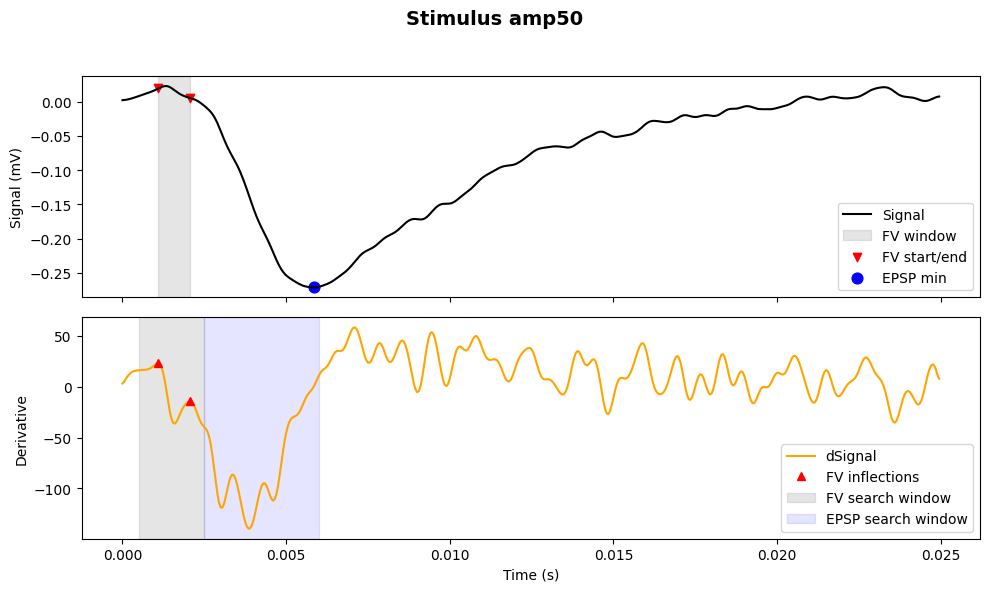

Stimulus amp500: FV start=0.001400s, end=0.002250s, amplitude=0.846 mV
Stimulus amp500: EPSP trough=-4.571 mV at 0.004100s
Stimulus amp500: EPSP amplitude=3.945321 mV


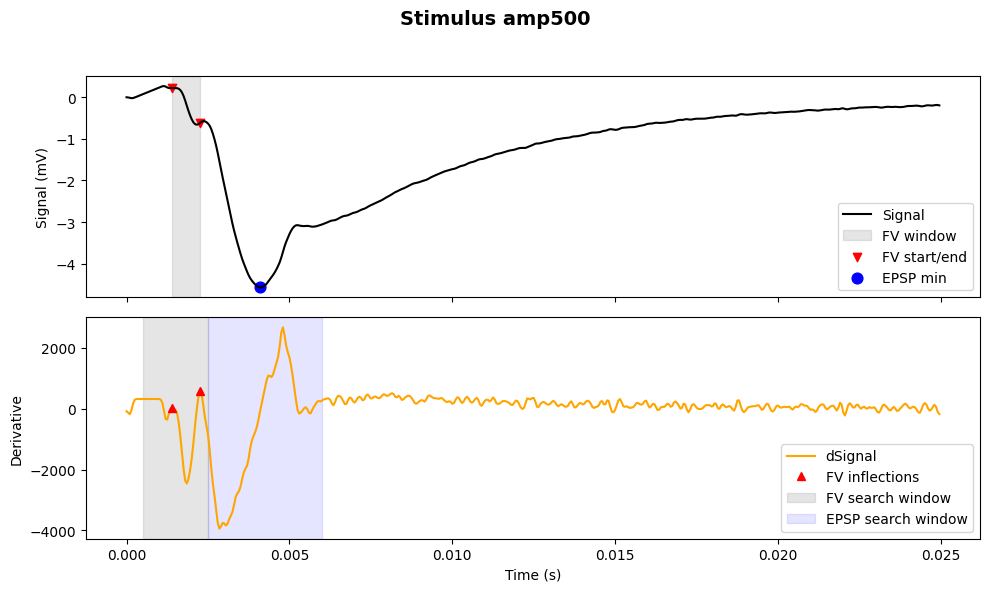

Stimulus amp600: FV start=0.001500s, end=0.002250s, amplitude=0.905 mV
Stimulus amp600: EPSP trough=-4.707 mV at 0.004000s
Stimulus amp600: EPSP amplitude=4.030192 mV


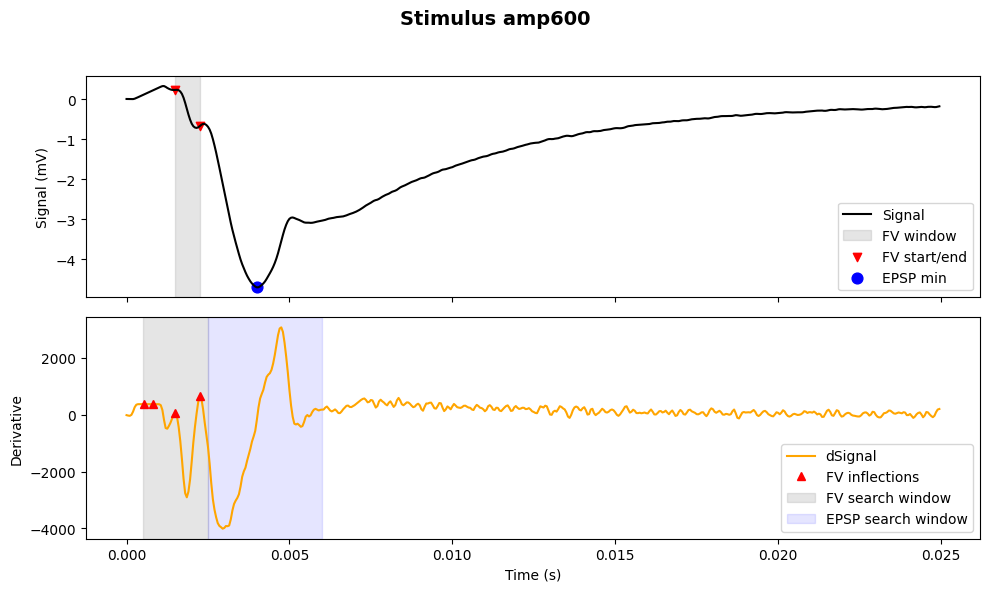

Stimulus amp75: FV start=0.001600s, end=0.002200s, amplitude=0.070 mV
Stimulus amp75: EPSP trough=-1.730 mV at 0.005550s
Stimulus amp75: EPSP amplitude=1.701433 mV


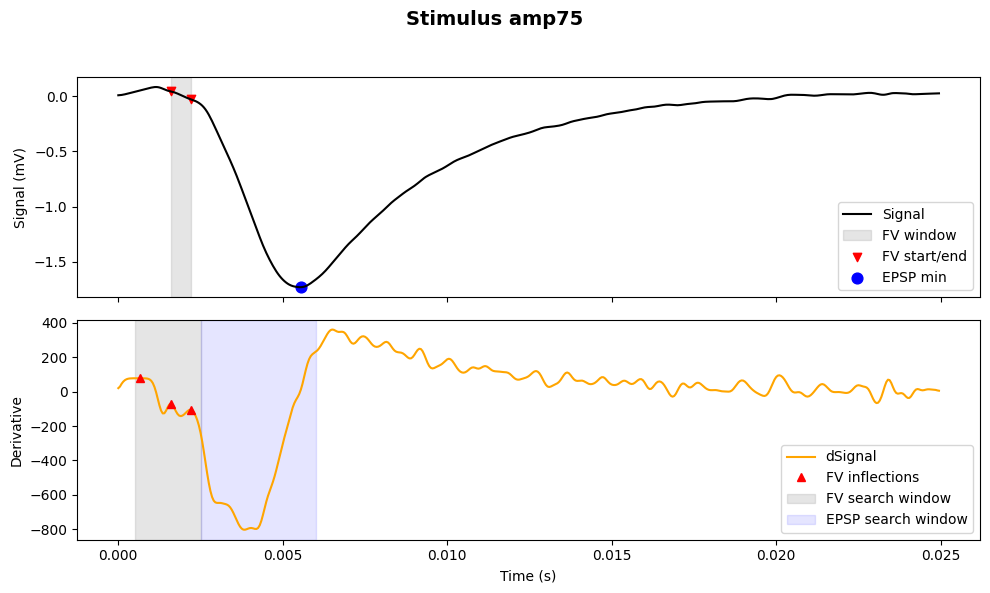

C:\Users\bbyer\AppData\Local\Temp\ipykernel_37124\1884855559.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ].apply(process_group)


,stimulus,time,mean_value,sem_value,mean_smooth,fv_min,fv_max,fv_amplitude,epsp_min_time,epsp_min_value,epsp_amplitude
0,amp100,0.00000,0.000000,0.000000,-0.029519,-0.083817,0.001696,0.085513,0.00530,-2.480172,2.396356
1,amp100,0.00005,-0.045776,0.000000,-0.029875,-0.083817,0.001696,0.085513,0.00530,-2.480172,2.396356
2,amp100,0.00010,-0.042089,0.000000,-0.030297,-0.083817,0.001696,0.085513,0.00530,-2.480172,2.396356
3,amp100,0.00015,-0.038401,0.000000,-0.030359,-0.083817,0.001696,0.085513,0.00530,-2.480172,2.396356
4,amp100,0.00020,-0.034714,0.000000,-0.029709,-0.083817,0.001696,0.085513,0.00530,-2.480172,2.396356
...,...,...,...,...,...,...,...,...,...,...,...
5495,amp75,0.02475,0.022380,0.010620,0.022981,-0.028245,0.041846,0.070091,0.00555,-1.729678,1.701433
5496,amp75,0.02480,0.014242,0.007121,0.023548,-0.028245,0.041846,0.070091,0.00555,-1.729678,1.701433
5497,amp75,0.02485,0.026449,0.007945,0.024079,-0.028245,0.041846,0.070091,0.00555,-1.729678,1.701433
5498,amp75,0.02490,0.025431,0.017383,0.024519,-0.028245,0.041846,0.070091,0.00555,-1.729678,1.701433


In [36]:
def calculate_epsp_slope(smoothed_df, fs=20e3):
    def process_group(group):
        g = group.copy()
        stim = group.name
        y = g["mean_smooth"].to_numpy()
        x = g["time"].to_numpy()

        # derivative
        dy = np.gradient(y, x)

        # FV and EPSP search windows (seconds)
        fv_start_search = 0.5e-3
        fv_end_search = 2.5e-3

        # find FV peaks in derivative
        start_idx = int(fv_start_search * fs)
        end_idx = int(fv_end_search * fs)
        slope_window = dy[start_idx:end_idx]
        x_window = x[start_idx:end_idx]
        peak_indices, _ = find_peaks(slope_window)

        fv_amp = np.nan
        fv_start = fv_end = None
        fv_min = fv_max = np.nan

        if len(peak_indices) >= 2:
            # take the last two peaks (fiber volley start and end)
            last_two = peak_indices[-2:]
            fv_start_idx = start_idx + last_two[0]
            fv_end_idx = start_idx + last_two[1]
            fv_start = x[fv_start_idx]
            fv_end = x[fv_end_idx]
            fv_max = y[fv_start_idx]
            fv_min = y[fv_end_idx]
            fv_amp = fv_max - fv_min
            print(f"Stimulus {stim}: FV start={fv_start:.6f}s, end={fv_end:.6f}s, amplitude={fv_amp:.3f} mV")
        else:
            print(f"Stimulus {stim}: insufficient FV peaks ({len(peak_indices)})")

        epsp_start_search = 2.5e-3
        epsp_end_search = 6e-3

        # EPSP trough search
        epsp_start_idx = int(epsp_start_search * fs)
        epsp_end_idx = int(epsp_end_search * fs)
        epsp_min_idx = epsp_start_idx + np.argmin(y[epsp_start_idx:epsp_end_idx])
        epsp_min_time = x[epsp_min_idx]
        epsp_min_value = y[epsp_min_idx]
        print(f"Stimulus {stim}: EPSP trough={epsp_min_value:.3f} mV at {epsp_min_time:.6f}s")

        # EPSP amplitude from FV_min to EPSP_min
        if not np.isnan(fv_min):
            epsp_amp = fv_min - epsp_min_value
            print(f"Stimulus {stim}: EPSP amplitude={epsp_amp:.6f} mV")
        else:
            epsp_amp = np.nan
            print(f"Stimulus {stim}: EPSP amplitude not found.")

        # plotting
        fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        fig.suptitle(f"Stimulus {stim}", fontsize=14, fontweight='bold')

        # top: signal with FV and EPSP markers
        axs[0].plot(x, y, color='black', label='Signal')
        if fv_start and fv_end:
            axs[0].axvspan(fv_start, fv_end, color='gray', alpha=0.2, label='FV window')
            axs[0].scatter([fv_start, fv_end],
                           [y[fv_start_idx], y[fv_end_idx]],
                           color='red', marker='v', label='FV start/end')
        axs[0].scatter(x[epsp_min_idx], y[epsp_min_idx],
                       color='blue', marker='o', s=60, label='EPSP min')
        axs[0].set_ylabel('Signal (mV)')
        axs[0].legend(loc='best')

        # bottom: derivative
        axs[1].plot(x, dy, color='orange', label='dSignal')
        axs[1].plot(x_window[peak_indices], slope_window[peak_indices], '^',
                    color='red', label='FV inflections')
        axs[1].axvspan(x[start_idx], x[end_idx], color='gray', alpha=0.2, label='FV search window')
        axs[1].axvspan(x[epsp_start_idx], x[epsp_end_idx], color='blue', alpha=0.1, label='EPSP search window')
        axs[1].set_ylabel('Derivative')
        axs[1].set_xlabel('Time (s)')
        axs[1].legend(loc='best')

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

        # store results
        g["fv_min"] = fv_min
        g["fv_max"] = fv_max
        g["fv_amplitude"] = fv_amp
        g["epsp_min_time"] = epsp_min_time
        g["epsp_min_value"] = epsp_min_value
        g["epsp_amplitude"] = epsp_amp

        return g

    return smoothed_df.groupby("stimulus", group_keys=False)[
        ['stimulus', 'time', 'mean_value', 'sem_value', 'mean_smooth']
    ].apply(process_group)

epsp = calculate_epsp_slope(smoothed)
display(epsp)

In [ ]:
def calculate_fv_and_epsp(smoothed_df, fs=20e3, )